In [ ]:
#a cnn for the famous cifar10 dataset

In [1]:
#imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#data imports and transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ColorJitter(brightness=0.2, saturation=0.3, hue=0.2, contrast=0.3),

    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.49139968, 0.48215827 ,0.44653124],[0.24703233, 0.24348505, 0.26158768])
    ])

training_set = torchvision.datasets.CIFAR10('/',train=True,download=True,transform=transform)
test_set = torchvision.datasets.CIFAR10('/', train=False, download=True, transform=transform)

training_dataloader = DataLoader(training_set, batch_size=32, shuffle = True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle = True)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


In [22]:
#model defination
class cnn(nn.Module):

    def __init__(self,in_channels,labels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(256,512,kernel_size=3,stride=2)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(512,256)
        self.bn11 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256,128)
        self.bn12 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128,64)
        self.bn13= nn.BatchNorm1d(64)

        self.fc4 = nn.Linear(64,labels)

    def forward(self,X):
        out = self.bn1(self.conv1(X))
        out = F.relu(out)

        out = self.bn2(self.conv2(out))
        out = F.relu(out)

        out = self.bn3(self.conv3(out))
        out = F.relu(out)
        out = self.pool3(out)

        out = self.bn4(self.conv4(out))
        out = F.relu(out)
        out = self.pool4(out)

        out = self.bn5(self.conv5(out))
        out = F.relu(out)
        out = self.pool5(out)

        out = self.flat(out)

        out = F.relu(self.bn11(self.fc1(out)))
        out = F.relu(self.bn12(self.fc2(out)))
        out = F.relu(self.bn13(self.fc3(out)))

        return self.fc4(out)

model = cnn(3,10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

n_epochs = 50
learning_rate = 0.001

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

Epoch 10: Loss = 0.6861018879508972
Epoch 20: Loss = 0.5261111712551116
Epoch 30: Loss = 0.4389540041780472
Epoch 40: Loss = 0.3793951253080368
Epoch 50: Loss = 0.3404180399656296


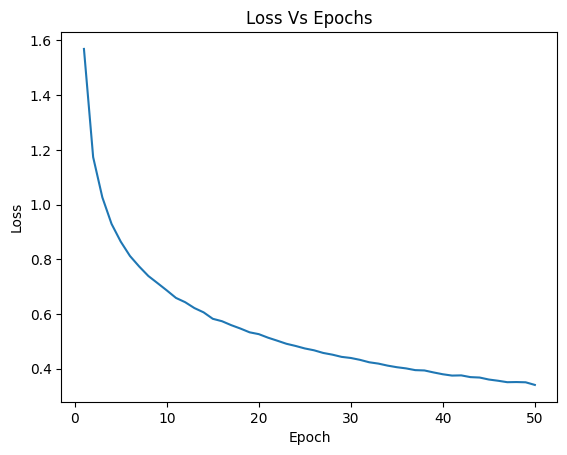

In [23]:
#training loop
graph = {}

for epoch in range(n_epochs):
    total_loss = 0
    for batch_x,batch_y in training_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_hat = model(batch_x)

        l = loss(y_hat,batch_y)

        l.backward()

        optimizer.step()

        optimizer.zero_grad()

        total_loss += l.item()

    avg_loss = (total_loss * training_dataloader.batch_size) / len(training_dataloader.dataset)
    graph[epoch+1] = avg_loss

    if (epoch+1)%10 == 0:
      print(f'Epoch {epoch+1}: Loss = {avg_loss}')

plt.title('Loss Vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(graph.keys(),graph.values())

In [24]:
#training set evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in training_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)

        _, predicted = torch.max(outputs, 1)

        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total * 100
print(f'Training Set Accuracy: {accuracy:.2f}%')

Training Set Accuracy: 90.25%


In [25]:
#test set evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch_x, batch_y in test_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_x)

        _, predicted = torch.max(outputs, 1)

        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total * 100
print(f'Test Set Accuracy: {accuracy:.2f}%')

Test Set Accuracy: 83.69%


In [ ]:
#the model has a little bias and is also overfitting. i could fix the bias by making the model more deeper and training for more epochs.
#i could also fix the overfitting problem by doing some more data augmentaion, adding l2 regularization and adding dropout. but,
#unfortunately i don't have the resources train such a model